# Virtual bidding in NYISO's markets


In this lab, we will implement a simple virtual trading strategy in New York
ISO's electricity markets. The goal is to maximize profits. We shall train our
model on price data from one year, and implement the strategy on the data from
the next year. How much can you earn with a certain daily budget? Say \$250K?

We will present a trading strategy. You are welcome to try other strategies and compare the gains over multiple runs.

Let's start with customary imports.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import choice
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pickle

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Load the day-ahead and real-time prices from 11 zones in New York.

The day-ahead prices are defined every hour. The real-time market runs every 5 minutes. For each zone, an average of
these prices over an hour is published.

Store the list of zones in the variable 'listOfZones'. Also, store the number of options
as the number of zones times the 24 hours available for trading. Finally create another
list containing the option names (zone + hour).

In [42]:
listOfZones = ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL', 'MHK VL',
               'MILLWD', 'N.Y.C.', 'NORTH', 'WEST']

nOptions = len(listOfZones) * 24
optionNames = [zone + "_Hour_" + str(t) for zone in listOfZones for t in range(24)]


## Parse the files with DA and RT prices along with DA load forecast.

Define a function that parses three files containing DA and RT prices, along with DA load predictions from a year from all different zones in the list defined before. This function will be used for to both load the data for training the classifiers and testing them. This function has 3 outputs: they are DA prices, difference between DA and RT prices, and finally DA load predictions. The outputs are pandas data frames whose columns are the options, and rows are the days in the year.

In [43]:
def loadNYISOData(year):

    # Open the relevant files for DA prices, RT prices, DA load.

    dfPriceDA = pd.read_csv("DAM_NYISO_Zonal_LBMP_" + str(year) + ".csv")
    dfPriceRT = pd.read_csv("RTM_NYISO_Zonal_LBMP_" + str(year) + ".csv")
    dfLoadDA = pd.read_csv("DAM_NYISO_LoadForecast_" + str(year) + ".csv")

    # Collect the DA and RT prices from each zone from each hour and create a pandas list.
    # The data should have prices and loads from all days of a year, where each day
    # contributes 24 rows, corresponding to each hour.

    priceDA = pd.DataFrame({zone: (dfPriceDA.loc[dfPriceDA['Zone Name'] == zone,
                                                 'DAM Zonal LBMP']).values
                             for zone in listOfZones})
    priceRT = pd.DataFrame({zone: (dfPriceRT.loc[dfPriceRT['Zone Name'] == zone,
                                                 'TWI Zonal LBMP']).values
                             for zone in listOfZones})
    loadDA = pd.DataFrame({zone: (dfLoadDA.loc[dfLoadDA['Zone Name'] == zone,
                                               'DAM Forecast Load']).values
                            for zone in listOfZones})

    numberOfDays = int(len(priceDA.index)/24)

    # Compute the price differences between DA and RT prices for all options on
    # all days of the year. Store it as a pandas data frame where the 24 rows for
    # each day is flattened into one row. This operation essentially allows us to
    # independently think of each zone in each hour as a separate option. Also,
    # reshape the prices for the DA market in the same manner.

    priceDART = pd.DataFrame([priceRT.sub(priceDA).loc[day * 24:
                                                              (day + 1) * 24 - 1,
                              listOfZones].values.flatten()
                              for day in range(numberOfDays)],
                             columns=optionNames)

    priceDA = pd.DataFrame([priceDA.loc[day * 24: (day + 1) * 24 - 1,
                            listOfZones].values.flatten()
                            for day in range(numberOfDays)],
                           columns=optionNames)

    return priceDA, priceDART, loadDA


## Create a function that creates the inputs for training a classifier

Create a function that takes the price and load data and creates two arrays
'X' and 'Y'. Essentially, the rows of 'X' contains all information relevant to
 predicting the sign of the price difference on the various options on the next day.
 It takes as an input, three pandas frames corresponding to the DA prices, price
 differences, and the DA load predictions, and produces three outputs:
 the arrays 'X', 'Y', and the range of days from the year that were used to
 create the data 'X' and 'Y'. This function will be used to both train and
 test classifiers.

In [44]:
def createClassifierIO(priceDA, priceDART, loadDA):

    # Define how many past days of prices to use for classification.

    pastPrices = range(1, 3)

    # Define how many past days of load predictions to use for classification.

    pastLoad = range(1, 3)

    # Define a date range within the year to create the arrays 'X' and 'Y' in a way
    # that past price and load data for the first day is within the date range in the
    # pandas frames passed as inputs.

    rangeOfDays = range(3, len(priceDA.index))

    # 'X' will contain three sets of variables:
    #   1. the DA prices from past days in the list 'pastDays',
    #   2. the differences between DA and RT prices from the same past days,
    #   3. the load predictions from past days in the list 'pastLoad'

    X = [np.concatenate((
        priceDA.loc[[(day - h) for h in pastPrices]].values.flatten(),
        priceDART.loc[[(day - h) for h in pastPrices]].values.flatten(),
        loadDA.loc[[(day - h) for h in pastLoad]].values.flatten()
    )) for day in rangeOfDays]

    # Scale the array 'X' to make its data zero mean and unit variance.
    X = StandardScaler().fit_transform(X)

    # 'Y' will contain zeros and ones, where a one indicates that the price in DA is
    # higher than in RT for a particular option. Recall that an option corresponds to
    # a zone at a particular hour of the day.

    Y = np.array([(priceDART.loc[day].values > 0).astype(int)
                  for day in rangeOfDays])

    # Return the arrays 'X' and 'Y', and finally the range of days from the year that
    # will be utilized for training or testing the classifier.
    return X, Y, rangeOfDays

## Design the training module.
 The training module utilizes a year's worth of data to determine the following for
 each option, i.e., for each zone for each hour of the day:
   1. Classifiers that predict the sign of the difference between DA and RT prices.
   2. Statistics of the mean of the price difference.
   3. A quantile of the day-ahead prices that we will use as our bid for each option.
 You will either train the classifiers here or load them from the folder './Classifiers'.
 Storing the classifiers from time to time allows you to only vary the bidding strategy
 and observe the annual reward rather than having to train the classifiers every time.
 
### Define and train the classifiers or load pre-trained classifiers.

In [45]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    classifiers = [MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=200)
                   for _ in range(nOptions)]

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")

Starting training module...

Loaded hourly prices from 2015 for 365 days.
Classifier trained for option CAPITL_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_1
Classifier trained for option CAPITL_Hour_2
Classifier trained for option CAPITL_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_4
Classifier trained for option CAPITL_Hour_5
Classifier trained for option CAPITL_Hour_6
Classifier trained for option CAPITL_Hour_7
Classifier trained for option CAPITL_Hour_8
Classifier trained for option CAPITL_Hour_9
Classifier trained for option CAPITL_Hour_10
Classifier trained for option CAPITL_Hour_11
Classifier trained for option CAPITL_Hour_12
Classifier trained for option CAPITL_Hour_13
Classifier trained for option CAPITL_Hour_14
Classifier trained for option CAPITL_Hour_15
Classifier trained for option CAPITL_Hour_16
Classifier trained for option CAPITL_Hour_17
Classifier trained for option CAPITL_Hour_18
Classifier trained for option CAPITL_Hour_19
Classifier trained for option CAPITL_Hour_20
Classifier trained for option CAPITL_Hour_21
Classifier trained for option CAPITL_Hour_22
Classifier trained for option CAPITL_Hour_23
Classifier trained for option CENTRL_Hour_0
Classifier trained for option CENTRL_Hour_1
Classifier trained

C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_11
Classifier trained for option CENTRL_Hour_12
Classifier trained for option CENTRL_Hour_13
Classifier trained for option CENTRL_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_15
Classifier trained for option CENTRL_Hour_16
Classifier trained for option CENTRL_Hour_17
Classifier trained for option CENTRL_Hour_18
Classifier trained for option CENTRL_Hour_19
Classifier trained for option CENTRL_Hour_20
Classifier trained for option CENTRL_Hour_21
Classifier trained for option CENTRL_Hour_22
Classifier trained for option CENTRL_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_0
Classifier trained for option DUNWOD_Hour_1
Classifier trained for option DUNWOD_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_3
Classifier trained for option DUNWOD_Hour_4
Classifier trained for option DUNWOD_Hour_5
Classifier trained for option DUNWOD_Hour_6
Classifier trained for option DUNWOD_Hour_7
Classifier trained for option DUNWOD_Hour_8
Classifier trained for option DUNWOD_Hour_9
Classifier trained for option DUNWOD_Hour_10
Classifier trained for option DUNWOD_Hour_11
Classifier trained for option DUNWOD_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_13
Classifier trained for option DUNWOD_Hour_14
Classifier trained for option DUNWOD_Hour_15
Classifier trained for option DUNWOD_Hour_16
Classifier trained for option DUNWOD_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_18
Classifier trained for option DUNWOD_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_20
Classifier trained for option DUNWOD_Hour_21
Classifier trained for option DUNWOD_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_0
Classifier trained for option GENESE_Hour_1
Classifier trained for option GENESE_Hour_2
Classifier trained for option GENESE_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_4
Classifier trained for option GENESE_Hour_5
Classifier trained for option GENESE_Hour_6
Classifier trained for option GENESE_Hour_7
Classifier trained for option GENESE_Hour_8
Classifier trained for option GENESE_Hour_9
Classifier trained for option GENESE_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_11
Classifier trained for option GENESE_Hour_12
Classifier trained for option GENESE_Hour_13
Classifier trained for option GENESE_Hour_14
Classifier trained for option GENESE_Hour_15
Classifier trained for option GENESE_Hour_16
Classifier trained for option GENESE_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_19
Classifier trained for option GENESE_Hour_20
Classifier trained for option GENESE_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_23
Classifier trained for option HUD VL_Hour_0
Classifier trained for option HUD VL_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_2
Classifier trained for option HUD VL_Hour_3
Classifier trained for option HUD VL_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_5
Classifier trained for option HUD VL_Hour_6
Classifier trained for option HUD VL_Hour_7
Classifier trained for option HUD VL_Hour_8
Classifier trained for option HUD VL_Hour_9
Classifier trained for option HUD VL_Hour_10
Classifier trained for option HUD VL_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_13
Classifier trained for option HUD VL_Hour_14
Classifier trained for option HUD VL_Hour_15
Classifier trained for option HUD VL_Hour_16
Classifier trained for option HUD VL_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_18
Classifier trained for option HUD VL_Hour_19
Classifier trained for option HUD VL_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_0
Classifier trained for option LONGIL_Hour_1
Classifier trained for option LONGIL_Hour_2
Classifier trained for option LONGIL_Hour_3
Classifier trained for option LONGIL_Hour_4
Classifier trained for option LONGIL_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_6
Classifier trained for option LONGIL_Hour_7
Classifier trained for option LONGIL_Hour_8
Classifier trained for option LONGIL_Hour_9
Classifier trained for option LONGIL_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_12
Classifier trained for option LONGIL_Hour_13
Classifier trained for option LONGIL_Hour_14
Classifier trained for option LONGIL_Hour_15
Classifier trained for option LONGIL_Hour_16
Classifier trained for option LONGIL_Hour_17
Classifier trained for option LONGIL_Hour_18
Classifier trained for option LONGIL_Hour_19
Classifier trained for option LONGIL_Hour_20
Classifier trained for option LONGIL_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_22
Classifier trained for option LONGIL_Hour_23
Classifier trained for option MHK VL_Hour_0
Classifier trained for option MHK VL_Hour_1
Classifier trained for option MHK VL_Hour_2
Classifier trained for option MHK VL_Hour_3
Classifier trained for option MHK VL_Hour_4
Classifier trained for option MHK VL_Hour_5
Classifier trained for option MHK VL_Hour_6
Classifier trained for option MHK VL_Hour_7
Classifier trained for option MHK VL_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_10
Classifier trained for option MHK VL_Hour_11
Classifier trained for option MHK VL_Hour_12
Classifier trained for option MHK VL_Hour_13
Classifier trained for option MHK VL_Hour_14
Classifier trained for option MHK VL_Hour_15
Classifier trained for option MHK VL_Hour_16
Classifier trained for option MHK VL_Hour_17
Classifier trained for option MHK VL_Hour_18
Classifier trained for option MHK VL_Hour_19
Classifier trained for option MHK VL_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_21
Classifier trained for option MHK VL_Hour_22
Classifier trained for option MHK VL_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_0
Classifier trained for option MILLWD_Hour_1
Classifier trained for option MILLWD_Hour_2
Classifier trained for option MILLWD_Hour_3
Classifier trained for option MILLWD_Hour_4
Classifier trained for option MILLWD_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_7
Classifier trained for option MILLWD_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_9
Classifier trained for option MILLWD_Hour_10
Classifier trained for option MILLWD_Hour_11
Classifier trained for option MILLWD_Hour_12
Classifier trained for option MILLWD_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_14
Classifier trained for option MILLWD_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_16
Classifier trained for option MILLWD_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_19
Classifier trained for option MILLWD_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_21
Classifier trained for option MILLWD_Hour_22
Classifier trained for option MILLWD_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_0
Classifier trained for option N.Y.C._Hour_1
Classifier trained for option N.Y.C._Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_3
Classifier trained for option N.Y.C._Hour_4
Classifier trained for option N.Y.C._Hour_5
Classifier trained for option N.Y.C._Hour_6
Classifier trained for option N.Y.C._Hour_7
Classifier trained for option N.Y.C._Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_9
Classifier trained for option N.Y.C._Hour_10
Classifier trained for option N.Y.C._Hour_11
Classifier trained for option N.Y.C._Hour_12
Classifier trained for option N.Y.C._Hour_13
Classifier trained for option N.Y.C._Hour_14
Classifier trained for option N.Y.C._Hour_15
Classifier trained for option N.Y.C._Hour_16
Classifier trained for option N.Y.C._Hour_17
Classifier trained for option N.Y.C._Hour_18
Classifier trained for option N.Y.C._Hour_19
Classifier trained for option N.Y.C._Hour_20
Classifier trained for option N.Y.C._Hour_21
Classifier trained for option N.Y.C._Hour_22
Classifier trained for option N.Y.C._Hour_23
Classifier trained for option NORTH_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_1
Classifier trained for option NORTH_Hour_2
Classifier trained for option NORTH_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_4
Classifier trained for option NORTH_Hour_5
Classifier trained for option NORTH_Hour_6
Classifier trained for option NORTH_Hour_7
Classifier trained for option NORTH_Hour_8
Classifier trained for option NORTH_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_10
Classifier trained for option NORTH_Hour_11
Classifier trained for option NORTH_Hour_12
Classifier trained for option NORTH_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_14
Classifier trained for option NORTH_Hour_15
Classifier trained for option NORTH_Hour_16
Classifier trained for option NORTH_Hour_17
Classifier trained for option NORTH_Hour_18
Classifier trained for option NORTH_Hour_19
Classifier trained for option NORTH_Hour_20
Classifier trained for option NORTH_Hour_21
Classifier trained for option NORTH_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_23
Classifier trained for option WEST_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_1
Classifier trained for option WEST_Hour_2
Classifier trained for option WEST_Hour_3
Classifier trained for option WEST_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_5
Classifier trained for option WEST_Hour_6
Classifier trained for option WEST_Hour_7
Classifier trained for option WEST_Hour_8
Classifier trained for option WEST_Hour_9
Classifier trained for option WEST_Hour_10
Classifier trained for option WEST_Hour_11
Classifier trained for option WEST_Hour_12
Classifier trained for option WEST_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_14
Classifier trained for option WEST_Hour_15
Classifier trained for option WEST_Hour_16
Classifier trained for option WEST_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_18
Classifier trained for option WEST_Hour_19
Classifier trained for option WEST_Hour_20
Classifier trained for option WEST_Hour_21
Classifier trained for option WEST_Hour_22
Classifier trained for option WEST_Hour_23

Overall training accuracy = 99.97 percent.


### Test the classifier's accuracy on test data.

In [46]:
# First, load the test data from NYISO for the year 2016. Again, utilize our function
# named 'loadNYISOData'.

print("Starting the testing module...\n")
testPriceDA, testPriceDART, testLoadDA = loadNYISOData(2016)

# Create the data for the classifier using the function 'createClassifierIO'.
testX, testY, rangeOfDays = createClassifierIO(testPriceDA, testPriceDART, testLoadDA)

# The next step is not useful for implementing the trading strategy, but quickly check how accurate
# your trained classifiers are for the test data. Training accuracy is not always indicative of
# test accuracy.

testingAccuracy = [classifiers[ii].score(testX, testY[:, ii]) for ii in range(nOptions)]
print("Test Accuracy Stats: Min = %.2f%%, Avg = %.2f%%, Max = %.2f%%" %
      (100 * np.min(testingAccuracy),
       100 * np.mean(testingAccuracy),
       100 * np.max(testingAccuracy)))

# Utilize the classifiers to predict the sign of DA - RT prices for each day in 'rangeOfDays' for
# the test data. Store the result in a pandas data frame with columns as the option names and the
# day in year as index.
predictedY = pd.DataFrame(np.column_stack([classifiers[ii].predict(testX) for ii in range(nOptions)]),
                          columns=optionNames, index=rangeOfDays)

Starting the testing module...

Test Accuracy Stats: Min = 48.76%, Avg = 59.00%, Max = 68.04%


## Design and implement the trading strategy. 

We define a fairly simple trading strategy. Define a total budget that you are willing to spend in the DA market. Recall that we only invest in
options where we buy at the DA market and sell at the RT market. When your bid for one unit of an option
clears in the DA market, you have to pay the DA price for that option. There are two possibilities:
  1. Your bid clears: Therefore, your offer price was higher than the DA price.
  2. Your bid does not clear: Then, the DA price was higher than your bid.
In both these cases, the maximum you have to pay is your bid. Therefore, we will enforce that your bids
across all options in a day does not exceed your total budget.
Keep track of how rewards grow (or fall) through the year
as you utilize your strategy. Also, keep track of how much rewards you get from each option. We shall
visualize these results after implementing the trading strategy over the NYISO data for 2016.

Choose the bid prices as a suitable quantile of the historical DA prices. The higher the quantile, the
better your chances are that your bid will be cleared. However, a higher quantile also indicates that
you are budgeting more money for each option, and hence, you will buy fewer options.

In [47]:
dailyBudget = 250000
quantileOffer =0.8

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = -88,710
Day 4: Reward (in $) = 1,038,436
Day 5: Reward (in $) = 3,441
Day 6: Reward (in $) = -24,600
Day 7: Reward (in $) = -10,636
Day 8: Reward (in $) = -38,029
Day 9: Reward (in $) = -33,905
Day 10: Reward (in $) = -112,249
Day 11: Reward (in $) = -45,986
Day 12: Reward (in $) = -38,097
Day 13: Reward (in $) = -15,536
Day 14: Reward (in $) = -21,047
Day 15: Reward (in $) = 8,463
Day 16: Reward (in $) = 37,712
Day 17: Reward (in $) = -77,218
Day 18: Reward (in $) = -26,598
Day 19: Reward (in $) = 13,236
Day 20: Reward (in $) = 2,197
Day 21: Reward (in $) = 31,024
Day 22: Reward (in $) = 83,847
Day 23: Reward (in $) = 37,879
Day 24: Reward (in $) = -40,196
Day 25: Reward (in $) = -51,852
Day 26: Reward (in $) = -30,208
Day 27: Reward (in $) = -6,276
Day 28: Reward (in $) = -15,936
Day 29: Reward (in $) = -27,471
Day 30: Reward (in $) = -56,926
Day 31: Reward (in $) = -24,211
Day 32: Reward (in $) = -8,355
Day 33: Reward (in $) = -254,179
Day 34: Reward (in $) = 

Day 259: Reward (in $) = -67,335
Day 260: Reward (in $) = -15,692
Day 261: Reward (in $) = 28,052
Day 262: Reward (in $) = 12,091
Day 263: Reward (in $) = -61,071
Day 264: Reward (in $) = -34,654
Day 265: Reward (in $) = -58,018
Day 266: Reward (in $) = -70,250
Day 267: Reward (in $) = -17,716
Day 268: Reward (in $) = -23,132
Day 269: Reward (in $) = -67,895
Day 270: Reward (in $) = -79,634
Day 271: Reward (in $) = -12,893
Day 272: Reward (in $) = -27,143
Day 273: Reward (in $) = -53,737
Day 274: Reward (in $) = 19,456
Day 275: Reward (in $) = 35,405
Day 276: Reward (in $) = 50,103
Day 277: Reward (in $) = -1,684
Day 278: Reward (in $) = 103,782
Day 279: Reward (in $) = 29,542
Day 280: Reward (in $) = 10,536
Day 281: Reward (in $) = -9,797
Day 282: Reward (in $) = -1,569
Day 283: Reward (in $) = -8,432
Day 284: Reward (in $) = 23,504
Day 285: Reward (in $) = -67,896
Day 286: Reward (in $) = -57,682
Day 287: Reward (in $) = -60,182
Day 288: Reward (in $) = 10,739
Day 289: Reward (in $) 

### Task1:  Visualize the rewards (25 points)

We would like to plot the cumulative reward over the year 2016. By cumulative reward on a particular date, we mean the total reward from the start of the year till that date.

Also, plot a heat map of the returns from each option. 

#### Fill in the missing lines below.

C:\Users\Katherine\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


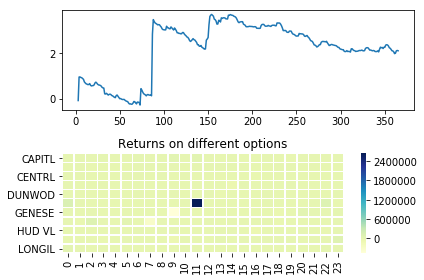

In [48]:
# Plot the cumulative reward over the year 2016. Also, plot a heat map of the returns from
# each option.

fig, axs = plt.subplots(2, 1, tight_layout=True)
axs = axs.ravel()


## Enter code here where you plot in axs[0].

rewards = sorted(cumulativeReward.items())
x, y = zip(*rewards)

axs[0].plot(x, y)



axs[1] = sns.heatmap(np.reshape(list(optionReturn.values()), (len(listOfZones), 24)),
                     linewidth=0.5,
                     cmap="YlGnBu")
axs[1].set_yticklabels(listOfZones, rotation=0)
axs[1].set_xticklabels(range(24), rotation=90)
axs[1].set_title('Returns on different options')
plt.show()


### Task 2: Choosing a classifier (25 points)

We used a multilayer perceptron classifier. Your task is to try out SVM and logistic regression classifiers, and explore which one leads to more profits. Use the relevant functions from 'sklearn'.

#### (comments here, add a new code cell below)

In [50]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    classifiers = [LogisticRegression()
                   for _ in range(nOptions)]

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")

Starting training module...

Loaded hourly prices from 2015 for 365 days.


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_17
Classifier trained for option CAPITL_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_20
Classifier trained for option CAPITL_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CAPITL_Hour_22
Classifier trained for option CAPITL_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_0
Classifier trained for option CENTRL_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_3
Classifier trained for option CENTRL_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option CENTRL_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_15
Classifier trained for option DUNWOD_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_17
Classifier trained for option DUNWOD_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option DUNWOD_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option GENESE_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option HUD VL_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option LONGIL_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MHK VL_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option MILLWD_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option N.Y.C._Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option NORTH_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_1


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_2


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_13


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_14


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier trained for option WEST_Hour_23

Overall training accuracy = 98.88 percent.


In [51]:
# First, load the test data from NYISO for the year 2016. Again, utilize our function
# named 'loadNYISOData'.

print("Starting the testing module...\n")
testPriceDA, testPriceDART, testLoadDA = loadNYISOData(2016)

# Create the data for the classifier using the function 'createClassifierIO'.
testX, testY, rangeOfDays = createClassifierIO(testPriceDA, testPriceDART, testLoadDA)

# The next step is not useful for implementing the trading strategy, but quickly check how accurate
# your trained classifiers are for the test data. Training accuracy is not always indicative of
# test accuracy.

testingAccuracy = [classifiers[ii].score(testX, testY[:, ii]) for ii in range(nOptions)]
print("Test Accuracy Stats: Min = %.2f%%, Avg = %.2f%%, Max = %.2f%%" %
      (100 * np.min(testingAccuracy),
       100 * np.mean(testingAccuracy),
       100 * np.max(testingAccuracy)))

# Utilize the classifiers to predict the sign of DA - RT prices for each day in 'rangeOfDays' for
# the test data. Store the result in a pandas data frame with columns as the option names and the
# day in year as index.
predictedY = pd.DataFrame(np.column_stack([classifiers[ii].predict(testX) for ii in range(nOptions)]),
                          columns=optionNames, index=rangeOfDays)

Starting the testing module...

Test Accuracy Stats: Min = 46.56%, Avg = 57.11%, Max = 66.94%


In [54]:
dailyBudget = 250000
quantileOffer =0.8

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = -68,526
Day 4: Reward (in $) = 1,479,037
Day 5: Reward (in $) = 26,671
Day 6: Reward (in $) = -11,287
Day 7: Reward (in $) = -33,478
Day 8: Reward (in $) = -3
Day 9: Reward (in $) = -41,039
Day 10: Reward (in $) = -103,550
Day 11: Reward (in $) = -66,561
Day 12: Reward (in $) = -19,243
Day 13: Reward (in $) = -29,134
Day 14: Reward (in $) = -38,464
Day 15: Reward (in $) = -1,356
Day 16: Reward (in $) = 42,492
Day 17: Reward (in $) = -68,046
Day 18: Reward (in $) = -21,816
Day 19: Reward (in $) = 15,207
Day 20: Reward (in $) = -5,257
Day 21: Reward (in $) = 30,907
Day 22: Reward (in $) = 125,165
Day 23: Reward (in $) = 28,234
Day 24: Reward (in $) = -86,143
Day 25: Reward (in $) = -88,304
Day 26: Reward (in $) = -17,552
Day 27: Reward (in $) = -7,409
Day 28: Reward (in $) = -12,490
Day 29: Reward (in $) = -22,572
Day 30: Reward (in $) = -35,468
Day 31: Reward (in $) = -47,171
Day 32: Reward (in $) = -11,490
Day 33: Reward (in $) = -57,629
Day 34: Reward (in $) = 2

Day 259: Reward (in $) = -38,901
Day 260: Reward (in $) = -30,983
Day 261: Reward (in $) = 69,118
Day 262: Reward (in $) = -9,698
Day 263: Reward (in $) = -61,984
Day 264: Reward (in $) = -40,200
Day 265: Reward (in $) = -4,367
Day 266: Reward (in $) = -86,427
Day 267: Reward (in $) = -8,748
Day 268: Reward (in $) = -22,424
Day 269: Reward (in $) = -83,326
Day 270: Reward (in $) = -71,025
Day 271: Reward (in $) = -8,358
Day 272: Reward (in $) = -25,295
Day 273: Reward (in $) = -42,914
Day 274: Reward (in $) = 22,657
Day 275: Reward (in $) = 23,255
Day 276: Reward (in $) = -21,963
Day 277: Reward (in $) = 73,734
Day 278: Reward (in $) = 140,182
Day 279: Reward (in $) = 1,369
Day 280: Reward (in $) = -26,492
Day 281: Reward (in $) = -11,524
Day 282: Reward (in $) = 12,380
Day 283: Reward (in $) = -5,394
Day 284: Reward (in $) = -31,806
Day 285: Reward (in $) = 16,605
Day 286: Reward (in $) = -53,484
Day 287: Reward (in $) = -63,063
Day 288: Reward (in $) = 4,230
Day 289: Reward (in $) = 

C:\Users\Katherine\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


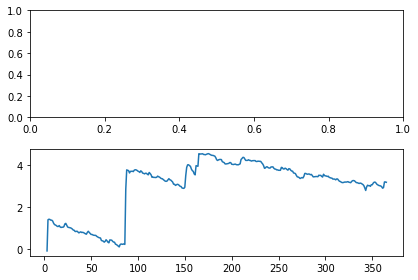

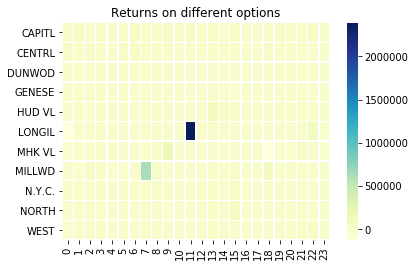

In [55]:
# Plot the cumulative reward over the year 2016. Also, plot a heat map of the returns from
# each option.

fig, axs = plt.subplots(2, 1, tight_layout=True)
axs = axs.ravel()


## Enter code here where you plot in axs[0].
rewards = sorted(cumulativeReward.items())
x, y = zip(*rewards)
axs[0] = plt.plot(x, y)
plt.show()


axs[1] = sns.heatmap(np.reshape(list(optionReturn.values()), (len(listOfZones), 24)),
                     linewidth=0.5,
                     cmap="YlGnBu")
axs[1].set_yticklabels(listOfZones, rotation=0)
axs[1].set_xticklabels(range(24), rotation=90)
axs[1].set_title('Returns on different options')
plt.show()

#### Answer:
The SVM classifier yields 1,085,980 dollars profit while the Logistic Regression classifier yields 3,169,844 dollars profit. Thus, Logistic Regression classifier yields larger profit.

### Task 3: Quantile (25 points)

For the best classifier, try different quanltile choices from the following list: 0.70, 0.75, 0.80, 0.85, 0.90, 0.95. Rank them in terms of profits (low to high). 

How do you expect the quantile to affect the portfolio? 

#### (comments here, add a new code cell below)

In [56]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    classifiers = [MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=200)
                   for _ in range(nOptions)]

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")

Starting training module...

Loaded hourly prices from 2015 for 365 days.
Classifier trained for option CAPITL_Hour_0
Classifier trained for option CAPITL_Hour_1
Classifier trained for option CAPITL_Hour_2
Classifier trained for option CAPITL_Hour_3
Classifier trained for option CAPITL_Hour_4
Classifier trained for option CAPITL_Hour_5
Classifier trained for option CAPITL_Hour_6
Classifier trained for option CAPITL_Hour_7
Classifier trained for option CAPITL_Hour_8
Classifier trained for option CAPITL_Hour_9
Classifier trained for option CAPITL_Hour_10
Classifier trained for option CAPITL_Hour_11
Classifier trained for option CAPITL_Hour_12
Classifier trained for option CAPITL_Hour_13
Classifier trained for option CAPITL_Hour_14
Classifier trained for option CAPITL_Hour_15
Classifier trained for option CAPITL_Hour_16
Classifier trained for option CAPITL_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_18
Classifier trained for option CAPITL_Hour_19
Classifier trained for option CAPITL_Hour_20
Classifier trained for option CAPITL_Hour_21
Classifier trained for option CAPITL_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_23
Classifier trained for option CENTRL_Hour_0
Classifier trained for option CENTRL_Hour_1
Classifier trained for option CENTRL_Hour_2
Classifier trained for option CENTRL_Hour_3
Classifier trained for option CENTRL_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_5
Classifier trained for option CENTRL_Hour_6
Classifier trained for option CENTRL_Hour_7
Classifier trained for option CENTRL_Hour_8
Classifier trained for option CENTRL_Hour_9
Classifier trained for option CENTRL_Hour_10
Classifier trained for option CENTRL_Hour_11
Classifier trained for option CENTRL_Hour_12
Classifier trained for option CENTRL_Hour_13
Classifier trained for option CENTRL_Hour_14
Classifier trained for option CENTRL_Hour_15


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_16
Classifier trained for option CENTRL_Hour_17
Classifier trained for option CENTRL_Hour_18
Classifier trained for option CENTRL_Hour_19
Classifier trained for option CENTRL_Hour_20
Classifier trained for option CENTRL_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_23
Classifier trained for option DUNWOD_Hour_0
Classifier trained for option DUNWOD_Hour_1
Classifier trained for option DUNWOD_Hour_2
Classifier trained for option DUNWOD_Hour_3
Classifier trained for option DUNWOD_Hour_4
Classifier trained for option DUNWOD_Hour_5
Classifier trained for option DUNWOD_Hour_6
Classifier trained for option DUNWOD_Hour_7
Classifier trained for option DUNWOD_Hour_8
Classifier trained for option DUNWOD_Hour_9
Classifier trained for option DUNWOD_Hour_10
Classifier trained for option DUNWOD_Hour_11
Classifier trained for option DUNWOD_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_13
Classifier trained for option DUNWOD_Hour_14
Classifier trained for option DUNWOD_Hour_15
Classifier trained for option DUNWOD_Hour_16
Classifier trained for option DUNWOD_Hour_17
Classifier trained for option DUNWOD_Hour_18
Classifier trained for option DUNWOD_Hour_19
Classifier trained for option DUNWOD_Hour_20
Classifier trained for option DUNWOD_Hour_21
Classifier trained for option DUNWOD_Hour_22
Classifier trained for option DUNWOD_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_0
Classifier trained for option GENESE_Hour_1
Classifier trained for option GENESE_Hour_2
Classifier trained for option GENESE_Hour_3
Classifier trained for option GENESE_Hour_4
Classifier trained for option GENESE_Hour_5
Classifier trained for option GENESE_Hour_6
Classifier trained for option GENESE_Hour_7
Classifier trained for option GENESE_Hour_8
Classifier trained for option GENESE_Hour_9
Classifier trained for option GENESE_Hour_10
Classifier trained for option GENESE_Hour_11
Classifier trained for option GENESE_Hour_12
Classifier trained for option GENESE_Hour_13
Classifier trained for option GENESE_Hour_14
Classifier trained for option GENESE_Hour_15
Classifier trained for option GENESE_Hour_16
Classifier trained for option GENESE_Hour_17
Classifier trained for option GENESE_Hour_18
Classifier trained for option GENESE_Hour_19
Classifier trained for option GENESE_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_21
Classifier trained for option GENESE_Hour_22
Classifier trained for option GENESE_Hour_23
Classifier trained for option HUD VL_Hour_0
Classifier trained for option HUD VL_Hour_1
Classifier trained for option HUD VL_Hour_2
Classifier trained for option HUD VL_Hour_3
Classifier trained for option HUD VL_Hour_4
Classifier trained for option HUD VL_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_6
Classifier trained for option HUD VL_Hour_7
Classifier trained for option HUD VL_Hour_8
Classifier trained for option HUD VL_Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_10
Classifier trained for option HUD VL_Hour_11
Classifier trained for option HUD VL_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_13
Classifier trained for option HUD VL_Hour_14
Classifier trained for option HUD VL_Hour_15
Classifier trained for option HUD VL_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_18
Classifier trained for option HUD VL_Hour_19
Classifier trained for option HUD VL_Hour_20
Classifier trained for option HUD VL_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_0
Classifier trained for option LONGIL_Hour_1
Classifier trained for option LONGIL_Hour_2
Classifier trained for option LONGIL_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_4
Classifier trained for option LONGIL_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_6
Classifier trained for option LONGIL_Hour_7
Classifier trained for option LONGIL_Hour_8
Classifier trained for option LONGIL_Hour_9
Classifier trained for option LONGIL_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_11
Classifier trained for option LONGIL_Hour_12
Classifier trained for option LONGIL_Hour_13
Classifier trained for option LONGIL_Hour_14
Classifier trained for option LONGIL_Hour_15
Classifier trained for option LONGIL_Hour_16
Classifier trained for option LONGIL_Hour_17
Classifier trained for option LONGIL_Hour_18
Classifier trained for option LONGIL_Hour_19
Classifier trained for option LONGIL_Hour_20
Classifier trained for option LONGIL_Hour_21


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_23
Classifier trained for option MHK VL_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_1
Classifier trained for option MHK VL_Hour_2
Classifier trained for option MHK VL_Hour_3
Classifier trained for option MHK VL_Hour_4
Classifier trained for option MHK VL_Hour_5
Classifier trained for option MHK VL_Hour_6
Classifier trained for option MHK VL_Hour_7
Classifier trained for option MHK VL_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_9
Classifier trained for option MHK VL_Hour_10
Classifier trained for option MHK VL_Hour_11
Classifier trained for option MHK VL_Hour_12
Classifier trained for option MHK VL_Hour_13
Classifier trained for option MHK VL_Hour_14
Classifier trained for option MHK VL_Hour_15
Classifier trained for option MHK VL_Hour_16
Classifier trained for option MHK VL_Hour_17
Classifier trained for option MHK VL_Hour_18
Classifier trained for option MHK VL_Hour_19
Classifier trained for option MHK VL_Hour_20


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_21
Classifier trained for option MHK VL_Hour_22
Classifier trained for option MHK VL_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_0


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_1
Classifier trained for option MILLWD_Hour_2
Classifier trained for option MILLWD_Hour_3


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_4
Classifier trained for option MILLWD_Hour_5


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_6
Classifier trained for option MILLWD_Hour_7
Classifier trained for option MILLWD_Hour_8
Classifier trained for option MILLWD_Hour_9
Classifier trained for option MILLWD_Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_11
Classifier trained for option MILLWD_Hour_12


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_13
Classifier trained for option MILLWD_Hour_14
Classifier trained for option MILLWD_Hour_15
Classifier trained for option MILLWD_Hour_16


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_17
Classifier trained for option MILLWD_Hour_18


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_19
Classifier trained for option MILLWD_Hour_20
Classifier trained for option MILLWD_Hour_21
Classifier trained for option MILLWD_Hour_22
Classifier trained for option MILLWD_Hour_23
Classifier trained for option N.Y.C._Hour_0
Classifier trained for option N.Y.C._Hour_1
Classifier trained for option N.Y.C._Hour_2
Classifier trained for option N.Y.C._Hour_3
Classifier trained for option N.Y.C._Hour_4
Classifier trained for option N.Y.C._Hour_5
Classifier trained for option N.Y.C._Hour_6
Classifier trained for option N.Y.C._Hour_7
Classifier trained for option N.Y.C._Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_9


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_10


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_11
Classifier trained for option N.Y.C._Hour_12
Classifier trained for option N.Y.C._Hour_13
Classifier trained for option N.Y.C._Hour_14
Classifier trained for option N.Y.C._Hour_15
Classifier trained for option N.Y.C._Hour_16
Classifier trained for option N.Y.C._Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_18
Classifier trained for option N.Y.C._Hour_19
Classifier trained for option N.Y.C._Hour_20
Classifier trained for option N.Y.C._Hour_21
Classifier trained for option N.Y.C._Hour_22


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_23
Classifier trained for option NORTH_Hour_0
Classifier trained for option NORTH_Hour_1
Classifier trained for option NORTH_Hour_2
Classifier trained for option NORTH_Hour_3
Classifier trained for option NORTH_Hour_4


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_5
Classifier trained for option NORTH_Hour_6


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_7


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_8


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_9
Classifier trained for option NORTH_Hour_10
Classifier trained for option NORTH_Hour_11
Classifier trained for option NORTH_Hour_12
Classifier trained for option NORTH_Hour_13
Classifier trained for option NORTH_Hour_14
Classifier trained for option NORTH_Hour_15
Classifier trained for option NORTH_Hour_16
Classifier trained for option NORTH_Hour_17
Classifier trained for option NORTH_Hour_18
Classifier trained for option NORTH_Hour_19


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_20
Classifier trained for option NORTH_Hour_21
Classifier trained for option NORTH_Hour_22
Classifier trained for option NORTH_Hour_23


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_0
Classifier trained for option WEST_Hour_1
Classifier trained for option WEST_Hour_2
Classifier trained for option WEST_Hour_3
Classifier trained for option WEST_Hour_4
Classifier trained for option WEST_Hour_5
Classifier trained for option WEST_Hour_6
Classifier trained for option WEST_Hour_7
Classifier trained for option WEST_Hour_8
Classifier trained for option WEST_Hour_9
Classifier trained for option WEST_Hour_10
Classifier trained for option WEST_Hour_11


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_12
Classifier trained for option WEST_Hour_13
Classifier trained for option WEST_Hour_14
Classifier trained for option WEST_Hour_15
Classifier trained for option WEST_Hour_16
Classifier trained for option WEST_Hour_17


C:\Users\Katherine\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_18
Classifier trained for option WEST_Hour_19
Classifier trained for option WEST_Hour_20
Classifier trained for option WEST_Hour_21
Classifier trained for option WEST_Hour_22
Classifier trained for option WEST_Hour_23

Overall training accuracy = 99.97 percent.


In [57]:
# First, load the test data from NYISO for the year 2016. Again, utilize our function
# named 'loadNYISOData'.

print("Starting the testing module...\n")
testPriceDA, testPriceDART, testLoadDA = loadNYISOData(2016)

# Create the data for the classifier using the function 'createClassifierIO'.
testX, testY, rangeOfDays = createClassifierIO(testPriceDA, testPriceDART, testLoadDA)

# The next step is not useful for implementing the trading strategy, but quickly check how accurate
# your trained classifiers are for the test data. Training accuracy is not always indicative of
# test accuracy.

testingAccuracy = [classifiers[ii].score(testX, testY[:, ii]) for ii in range(nOptions)]
print("Test Accuracy Stats: Min = %.2f%%, Avg = %.2f%%, Max = %.2f%%" %
      (100 * np.min(testingAccuracy),
       100 * np.mean(testingAccuracy),
       100 * np.max(testingAccuracy)))

# Utilize the classifiers to predict the sign of DA - RT prices for each day in 'rangeOfDays' for
# the test data. Store the result in a pandas data frame with columns as the option names and the
# day in year as index.
predictedY = pd.DataFrame(np.column_stack([classifiers[ii].predict(testX) for ii in range(nOptions)]),
                          columns=optionNames, index=rangeOfDays)

Starting the testing module...

Test Accuracy Stats: Min = 49.04%, Avg = 59.05%, Max = 68.60%


In [58]:
dailyBudget = 250000
quantileOffer =0.95

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = 3,826
Day 4: Reward (in $) = 530,490
Day 5: Reward (in $) = 14,484
Day 6: Reward (in $) = -31,308
Day 7: Reward (in $) = -8,843
Day 8: Reward (in $) = 8,886
Day 9: Reward (in $) = -23,235
Day 10: Reward (in $) = -67,160
Day 11: Reward (in $) = -50,925
Day 12: Reward (in $) = -37,475
Day 13: Reward (in $) = -34,596
Day 14: Reward (in $) = -34,869
Day 15: Reward (in $) = -1,134
Day 16: Reward (in $) = 23,061
Day 17: Reward (in $) = -38,671
Day 18: Reward (in $) = -17,131
Day 19: Reward (in $) = 6,081
Day 20: Reward (in $) = -7,799
Day 21: Reward (in $) = 12,008
Day 22: Reward (in $) = 54,445
Day 23: Reward (in $) = 24,169
Day 24: Reward (in $) = -25,555
Day 25: Reward (in $) = -16,022
Day 26: Reward (in $) = -11,588
Day 27: Reward (in $) = -4,892
Day 28: Reward (in $) = -9,129
Day 29: Reward (in $) = -16,388
Day 30: Reward (in $) = -20,651
Day 31: Reward (in $) = -24,973
Day 32: Reward (in $) = -5,645
Day 33: Reward (in $) = -35,363
Day 34: Reward (in $) = -4,280
D

Day 259: Reward (in $) = -20,600
Day 260: Reward (in $) = -25,212
Day 261: Reward (in $) = 16,372
Day 262: Reward (in $) = -7,367
Day 263: Reward (in $) = 43,781
Day 264: Reward (in $) = -63,952
Day 265: Reward (in $) = -30,794
Day 266: Reward (in $) = -52,462
Day 267: Reward (in $) = -9,552
Day 268: Reward (in $) = -12,584
Day 269: Reward (in $) = -41,517
Day 270: Reward (in $) = -42,053
Day 271: Reward (in $) = -6,442
Day 272: Reward (in $) = -8,914
Day 273: Reward (in $) = -16,048
Day 274: Reward (in $) = 6,030
Day 275: Reward (in $) = 17,478
Day 276: Reward (in $) = 4,354
Day 277: Reward (in $) = 64,190
Day 278: Reward (in $) = 187,022
Day 279: Reward (in $) = 45,070
Day 280: Reward (in $) = 7,331
Day 281: Reward (in $) = -6,245
Day 282: Reward (in $) = 652
Day 283: Reward (in $) = -10,964
Day 284: Reward (in $) = 8,161
Day 285: Reward (in $) = 6,846
Day 286: Reward (in $) = -36,652
Day 287: Reward (in $) = -23,604
Day 288: Reward (in $) = 8,103
Day 289: Reward (in $) = 10,496
Day 

### Task 4: Daily budget (25 points)

We used a daily budget of 250,000. Try different budgets, let's say, 100,000, 150,000, 200,000, and 300,000. Rank them in terms of profits (low to high). Fix the quantile to the one that led to maximum profits in the previous task. 

#### (comments here, add a new code cell below)

In [59]:
dailyBudget = 300000
quantileOffer =0.7

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = -79,584
Day 4: Reward (in $) = 1,188,800
Day 5: Reward (in $) = 34,280
Day 6: Reward (in $) = -21,752
Day 7: Reward (in $) = -12,560
Day 8: Reward (in $) = 27,097
Day 9: Reward (in $) = -54,827
Day 10: Reward (in $) = -139,145
Day 11: Reward (in $) = -106,674
Day 12: Reward (in $) = -76,502
Day 13: Reward (in $) = -67,128
Day 14: Reward (in $) = -81,447
Day 15: Reward (in $) = -3,819
Day 16: Reward (in $) = 51,060
Day 17: Reward (in $) = -87,604
Day 18: Reward (in $) = -35,478
Day 19: Reward (in $) = 10,289
Day 20: Reward (in $) = -16,209
Day 21: Reward (in $) = 38,944
Day 22: Reward (in $) = 112,048
Day 23: Reward (in $) = 41,399
Day 24: Reward (in $) = -57,823
Day 25: Reward (in $) = -27,434
Day 26: Reward (in $) = -34,337
Day 27: Reward (in $) = -14,392
Day 28: Reward (in $) = -20,167
Day 29: Reward (in $) = -38,483
Day 30: Reward (in $) = -42,560
Day 31: Reward (in $) = -49,481
Day 32: Reward (in $) = -12,259
Day 33: Reward (in $) = -75,618
Day 34: Reward (in

Day 260: Reward (in $) = -64,495
Day 261: Reward (in $) = 44,279
Day 262: Reward (in $) = 19,946
Day 263: Reward (in $) = -152
Day 264: Reward (in $) = -4,893
Day 265: Reward (in $) = -2,015
Day 266: Reward (in $) = -12,814
Day 267: Reward (in $) = -22,507
Day 268: Reward (in $) = -27,318
Day 269: Reward (in $) = -93,556
Day 270: Reward (in $) = -98,009
Day 271: Reward (in $) = -14,672
Day 272: Reward (in $) = -23,711
Day 273: Reward (in $) = -50,162
Day 274: Reward (in $) = 19,060
Day 275: Reward (in $) = 53,799
Day 276: Reward (in $) = 12,985
Day 277: Reward (in $) = 144,409
Day 278: Reward (in $) = 406,958
Day 279: Reward (in $) = 28,204
Day 280: Reward (in $) = 24,938
Day 281: Reward (in $) = -14,631
Day 282: Reward (in $) = 2,577
Day 283: Reward (in $) = -7,341
Day 284: Reward (in $) = 33,173
Day 285: Reward (in $) = 24,357
Day 286: Reward (in $) = -89,581
Day 287: Reward (in $) = -57,173
Day 288: Reward (in $) = 26,588
Day 289: Reward (in $) = 24,620
Day 290: Reward (in $) = 12,0

#### Answer:
Profit for dailyBudget = 100000: 2,045,769 Profit for dailyBudget = 150000: 3,120,598 Profit for dailyBudget = 200000: 4,060,875 Profit for dailyBudget = 300000: 6,075,765. To rank from low profit to hight profit: 100000<150000<200000<300000 Thus as dailyBudget gets increases, the corresponding profit also gets larger.

### Task 6: Beat the algorithm! (25 points, bonus) 

Make changes to increase the profits further! The people with the top 20 total profits will get additional points. Exaplain what did for improvement and how much profits you made. Do not exceed the 250,000 budget!

#### (comments here, add a new code cell below)

In [60]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    classifiers = [MLPClassifier(hidden_layer_sizes=(40, 20), max_iter=300)
                   for _ in range(nOptions)]

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")

Starting training module...

Loaded hourly prices from 2015 for 365 days.
Classifier trained for option CAPITL_Hour_0
Classifier trained for option CAPITL_Hour_1
Classifier trained for option CAPITL_Hour_2
Classifier trained for option CAPITL_Hour_3
Classifier trained for option CAPITL_Hour_4
Classifier trained for option CAPITL_Hour_5
Classifier trained for option CAPITL_Hour_6
Classifier trained for option CAPITL_Hour_7
Classifier trained for option CAPITL_Hour_8
Classifier trained for option CAPITL_Hour_9
Classifier trained for option CAPITL_Hour_10
Classifier trained for option CAPITL_Hour_11
Classifier trained for option CAPITL_Hour_12
Classifier trained for option CAPITL_Hour_13
Classifier trained for option CAPITL_Hour_14
Classifier trained for option CAPITL_Hour_15
Classifier trained for option CAPITL_Hour_16
Classifier trained for option CAPITL_Hour_17
Classifier trained for option CAPITL_Hour_18
Classifier trained for option CAPITL_Hour_19
Classifier trained for option CAPITL

Classifier trained for option MILLWD_Hour_15
Classifier trained for option MILLWD_Hour_16
Classifier trained for option MILLWD_Hour_17
Classifier trained for option MILLWD_Hour_18
Classifier trained for option MILLWD_Hour_19
Classifier trained for option MILLWD_Hour_20
Classifier trained for option MILLWD_Hour_21
Classifier trained for option MILLWD_Hour_22
Classifier trained for option MILLWD_Hour_23
Classifier trained for option N.Y.C._Hour_0
Classifier trained for option N.Y.C._Hour_1
Classifier trained for option N.Y.C._Hour_2
Classifier trained for option N.Y.C._Hour_3
Classifier trained for option N.Y.C._Hour_4
Classifier trained for option N.Y.C._Hour_5
Classifier trained for option N.Y.C._Hour_6
Classifier trained for option N.Y.C._Hour_7
Classifier trained for option N.Y.C._Hour_8
Classifier trained for option N.Y.C._Hour_9
Classifier trained for option N.Y.C._Hour_10
Classifier trained for option N.Y.C._Hour_11
Classifier trained for option N.Y.C._Hour_12
Classifier trained f

In [61]:
# First, load the test data from NYISO for the year 2016. Again, utilize our function
# named 'loadNYISOData'.

print("Starting the testing module...\n")
testPriceDA, testPriceDART, testLoadDA = loadNYISOData(2016)

# Create the data for the classifier using the function 'createClassifierIO'.
testX, testY, rangeOfDays = createClassifierIO(testPriceDA, testPriceDART, testLoadDA)

# The next step is not useful for implementing the trading strategy, but quickly check how accurate
# your trained classifiers are for the test data. Training accuracy is not always indicative of
# test accuracy.

testingAccuracy = [classifiers[ii].score(testX, testY[:, ii]) for ii in range(nOptions)]
print("Test Accuracy Stats: Min = %.2f%%, Avg = %.2f%%, Max = %.2f%%" %
      (100 * np.min(testingAccuracy),
       100 * np.mean(testingAccuracy),
       100 * np.max(testingAccuracy)))

# Utilize the classifiers to predict the sign of DA - RT prices for each day in 'rangeOfDays' for
# the test data. Store the result in a pandas data frame with columns as the option names and the
# day in year as index.
predictedY = pd.DataFrame(np.column_stack([classifiers[ii].predict(testX) for ii in range(nOptions)]),
                          columns=optionNames, index=rangeOfDays)

Starting the testing module...

Test Accuracy Stats: Min = 47.38%, Avg = 59.63%, Max = 70.80%


In [62]:
dailyBudget = 250000
quantileOffer =0.7

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = -67,642
Day 4: Reward (in $) = 1,296,088
Day 5: Reward (in $) = 58,248
Day 6: Reward (in $) = -19,891
Day 7: Reward (in $) = -4,183
Day 8: Reward (in $) = 32,022
Day 9: Reward (in $) = -42,820
Day 10: Reward (in $) = -120,605
Day 11: Reward (in $) = -38,585
Day 12: Reward (in $) = -19,766
Day 13: Reward (in $) = -14,818
Day 14: Reward (in $) = -22,586
Day 15: Reward (in $) = 10,781
Day 16: Reward (in $) = 29,843
Day 17: Reward (in $) = -76,047
Day 18: Reward (in $) = -37,590
Day 19: Reward (in $) = 35,637
Day 20: Reward (in $) = 8,628
Day 21: Reward (in $) = 47,122
Day 22: Reward (in $) = 95,669
Day 23: Reward (in $) = 32,979
Day 24: Reward (in $) = -94,371
Day 25: Reward (in $) = -99,973
Day 26: Reward (in $) = -26,411
Day 27: Reward (in $) = -11,177
Day 28: Reward (in $) = -18,002
Day 29: Reward (in $) = -31,653
Day 30: Reward (in $) = -77,141
Day 31: Reward (in $) = -47,192
Day 32: Reward (in $) = -9,567
Day 33: Reward (in $) = -105,190
Day 34: Reward (in $) =

Day 261: Reward (in $) = 25,637
Day 262: Reward (in $) = 12,157
Day 263: Reward (in $) = -33,185
Day 264: Reward (in $) = -4,001
Day 265: Reward (in $) = -4,262
Day 266: Reward (in $) = -10,537
Day 267: Reward (in $) = -19,027
Day 268: Reward (in $) = -23,916
Day 269: Reward (in $) = -93,422
Day 270: Reward (in $) = -80,300
Day 271: Reward (in $) = -61,188
Day 272: Reward (in $) = -35,018
Day 273: Reward (in $) = -50,417
Day 274: Reward (in $) = 14,055
Day 275: Reward (in $) = 31,941
Day 276: Reward (in $) = 5,650
Day 277: Reward (in $) = 68,605
Day 278: Reward (in $) = 155,111
Day 279: Reward (in $) = 8,284
Day 280: Reward (in $) = 16,845
Day 281: Reward (in $) = -13,693
Day 282: Reward (in $) = 1,351
Day 283: Reward (in $) = -7,364
Day 284: Reward (in $) = 27,460
Day 285: Reward (in $) = -69,664
Day 286: Reward (in $) = -62,155
Day 287: Reward (in $) = -55,178
Day 288: Reward (in $) = 14,273
Day 289: Reward (in $) = 20,095
Day 290: Reward (in $) = 6,774
Day 291: Reward (in $) = -12,7

#### Answer:
I tried to increase the number of network layers

### Task 7: Implement a different trading strategy (25 points, bonus) 

Implement a different trading strategy, explain it and report its outcomes. If the rewards are comparable to the one discussed in class, and you can clearly explain the logic behind you strategy, you get additional 25 points. If your strategy leads to having profits among the top 20, then you automatically completed Task 6 too! 

#### (comments here, add a new code cell below)